## Цель: 

**Создать модель для классификации комментариев.**

## Подготовка

In [1]:
#загрузим библиотеки
import pandas as pd
import numpy as np 
import nltk
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer 
from nltk.corpus import stopwords
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from nltk import sent_tokenize, word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm
nltk.download('punkt')
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
#удали стобец без смысловой нагрузки
data = data.drop(['Unnamed: 0'], axis=1)

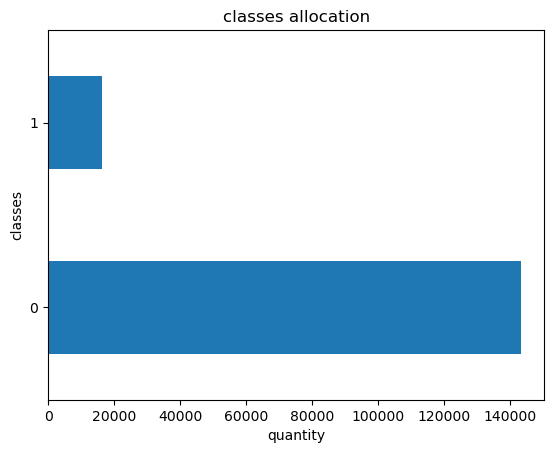

In [6]:
#проверим соотношение классов
data['toxic'] = data['toxic'].astype('category')
data['toxic'].value_counts().plot(kind='barh', xlabel='quantity', ylabel='classes', title='classes allocation');

**Смотря на график, можно убедиться в приличном дисбалансе классов с преобладанием негативных комментариев.**

In [8]:
data['text'] = data['text'].str.lower()

In [9]:
data['text']

0         explanation\nwhy the edits made under my usern...
1         d'aww! he matches this background colour i'm s...
2         hey man, i'm really not trying to edit war. it...
3         "\nmore\ni can't make any real suggestions on ...
4         you, sir, are my hero. any chance you remember...
                                ...                        
159287    ":::::and for the second time of asking, when ...
159288    you should be ashamed of yourself \n\nthat is ...
159289    spitzer \n\numm, theres no actual article for ...
159290    and it looks like it was actually you who put ...
159291    "\nand ... i really don't think you understand...
Name: text, Length: 159292, dtype: object

In [10]:
#функция для очистки текста от лишних символов и цифр
def clear_text(text):
    a = re.sub(r"([^a-zA-Z'])", ' ' , text)
    a = a.split()
    return ' '.join(a)

In [11]:
df = data['text'].apply(clear_text)

In [12]:
df

0         explanation why the edits made under my userna...
1         d'aww he matches this background colour i'm se...
2         hey man i'm really not trying to edit war it's...
3         more i can't make any real suggestions on impr...
4         you sir are my hero any chance you remember wh...
                                ...                        
159287    and for the second time of asking when your vi...
159288    you should be ashamed of yourself that is a ho...
159289    spitzer umm theres no actual article for prost...
159290    and it looks like it was actually you who put ...
159291    and i really don't think you understand i came...
Name: text, Length: 159292, dtype: object

In [13]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [14]:
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize_sent(text): 
    return " ".join([wnl.lemmatize(word, pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))])

lemmatize_sent('He is walking to school')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'He be walk to school'

In [15]:
tqdm.pandas()
                                                                            
df = df.progress_apply(lemmatize_sent)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [17]:
df

0         explanation why the edits make under my userna...
1         d'aww he match this background colour i 'm see...
2         hey man i 'm really not try to edit war it 's ...
3         more i ca n't make any real suggestion on impr...
4         you sir be my hero any chance you remember wha...
                                ...                        
159287    and for the second time of ask when your view ...
159288    you should be ashamed of yourself that be a ho...
159289    spitzer umm theres no actual article for prost...
159290    and it look like it be actually you who put on...
159291    and i really do n't think you understand i com...
Name: text, Length: 159292, dtype: object

In [18]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
#разобъем на train и test
feat_train, feat_test, target_train, target_test = train_test_split(df, data['toxic'])

In [20]:
#векторизируем комментарции 
count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))
count_tf_idf.fit(feat_train)

#feat_train = count_tf_idf.transform(feat_train)
feat_test = count_tf_idf.transform(feat_test)

## Обучение


In [22]:
#создадим функцию для удобства
def mod_result(model, params:dict, feat, target):
    pipe = Pipeline(steps=[("vect", TfidfVectorizer(stop_words=list(stopwords))), ("model", model)])
    random_cv = RandomizedSearchCV(
        pipe,
        params,
        scoring='f1',
        n_jobs=1,
        cv=2,
        random_state=111
    )

    random_cv.fit(feat, target)
    return 'F1_score: {}'.format(round(random_cv.best_score_, 5)), random_cv.best_params_, random_cv.best_estimator_

**Так как в данных есть дисбаланс классов, то добавим в модели class_weight = "balanced"**

**Я закомментировал все модели, кроме LogisticRegression, так как время их обучения слишком большое. Подождав достаточно времени были пoлучены результаты, которые оказались хуже LogisticRegression.**

In [24]:
model = mod_result(LogisticRegression(random_state=111, class_weight="balanced"), {'model__C':np.arange(0,10,1)}, feat_train, target_train)

In [ ]:
#mod_result(lgb.LGBMClassifier(random_state=111, class_weight="balanced"), {'max_depth':np.arange(0,10,1)}, feat_train, target_train)

In [ ]:
#mod_result(DecisionTreeClassifier(random_state=111, class_weight="balanced"), feat_train, target_train)

In [ ]:
#mod_result(CatBoostClassifier(random_state=111, class_weight="balanced"), feat_train, target_train)

In [26]:
model[0]

'F1_score: 0.75141'

**Лучше всего себя показала модель LogisticRegression с f1_score на train выборке = 0.7537 c параметром C=9**

**Проверим LogisticRegression на тестовой выборке**

In [27]:
#mod_l = LogisticRegression(random_state=111, class_weight="balanced", C=6)
#mod_l.fit(feat_train, target_train)
pred = model[2][1].predict(feat_test)
print(f"f1_score: {f1_score(target_test, pred)}")

f1_score: 0.7647992742118396


## Выводы

**При знакомстве с датасетом был замечен дисбаланс классов, который был минимизирован при помощи параметра 'class_weight'. После подготовки данных и обучении нескольких моделей, лучше всего себя показала модель LogisticRegression с f1_score на train выборке = 0.75141, а на test выборке f1_score = 0.7648**